# Machine Learning Engineer Nanodegree
## Deep Learning - TensorFlow & Keras
# &#x1F4D1; &nbsp;  P9: Image Classification

## Code Library and Links
- [A Guide to TF Layers: Building a Convolutional Neural Network](https://www.tensorflow.org/tutorials/layers)
- [Convnets in TensorFlow](http://web.stanford.edu/class/cs20si/lectures/slides_07.pdf)
- [Keras: Deep Learning library for Theano and TensorFlow](https://keras.io/)

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: #ddd1e7;} 
a {color: #9b30ff; font-family: 'Roboto';} 
h1 {color: #551a8b; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #551a8b; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #9b30ff;}      
div.output_stderr pre {background-color: #ddd1e7;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #551a8b; background: #ddd1e7; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                       

In [3]:
hide_code = ''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import random
import pickle
import tarfile

from tqdm import tqdm
from urllib.request import urlretrieve
from os.path import isfile, isdir
from unittest.mock import MagicMock

from IPython.display import display, Image, IFrame
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox

import tensorflow as tf
import keras as ks
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential, load_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [4]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/image-classification/helper.py

def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))

def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2, figsize=(9,9))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) \
    in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width, color='#9b30ff')
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [6]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/image-classification/problem_unittests.py

def _print_success_message():
    print('Tests Passed')

def test_folder_path(cifar10_dataset_folder_path):
    assert cifar10_dataset_folder_path is not None,\
        'Cifar-10 data folder not set.'
    assert cifar10_dataset_folder_path[-1] != '/',\
        'The "/" shouldn\'t be added to the end of the path.'
    assert os.path.exists(cifar10_dataset_folder_path),\
        'Path not found.'
    assert os.path.isdir(cifar10_dataset_folder_path),\
        '{} is not a folder.'.format(os.path.basename(cifar10_dataset_folder_path))

    train_files = [cifar10_dataset_folder_path + '/data_batch_' + str(batch_id) for batch_id in range(1, 6)]
    other_files = [cifar10_dataset_folder_path + '/batches.meta', cifar10_dataset_folder_path + '/test_batch']
    missing_files = [path for path in train_files + other_files if not os.path.exists(path)]

    assert not missing_files,\
        'Missing files in directory: {}'.format(missing_files)

    print('All files found!')

def test_normalize(normalize):
    test_shape = (np.random.choice(range(1000)), 32, 32, 3)
    test_numbers = np.random.choice(range(256), test_shape)
    normalize_out = normalize(test_numbers)

    assert type(normalize_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert normalize_out.shape == test_shape,\
        'Incorrect Shape. {} shape found'.format(normalize_out.shape)

    assert normalize_out.max() <= 1 and normalize_out.min() >= 0,\
        'Incorect Range. {} to {} found'.format(normalize_out.min(), normalize_out.max())

    _print_success_message()

def test_one_hot_encode(one_hot_encode):
    test_shape = np.random.choice(range(1000))
    test_numbers = np.random.choice(range(10), test_shape)
    one_hot_out = one_hot_encode(test_numbers)

    assert type(one_hot_out).__module__ == np.__name__,\
        'Not Numpy Object'

    assert one_hot_out.shape == (test_shape, 10),\
        'Incorrect Shape. {} shape found'.format(one_hot_out.shape)

    n_encode_tests = 5
    test_pairs = list(zip(test_numbers, one_hot_out))
    test_indices = np.random.choice(len(test_numbers), n_encode_tests)
    labels = [test_pairs[test_i][0] for test_i in test_indices]
    enc_labels = np.array([test_pairs[test_i][1] for test_i in test_indices])
    new_enc_labels = one_hot_encode(labels)

    assert np.array_equal(enc_labels, new_enc_labels),\
        'Encodings returned different results for the same numbers.\n' \
        'For the first call it returned:\n' \
        '{}\n' \
        'For the second call it returned\n' \
        '{}\n' \
        'Make sure you save the map of labels to encodings outside of the function.'.\
        format(enc_labels, new_enc_labels)

    _print_success_message()

def test_nn_image_inputs(neural_net_image_input):
    image_shape = (32, 32, 3)
    nn_inputs_out_x = neural_net_image_input(image_shape)

    assert nn_inputs_out_x.get_shape().as_list() == [None, image_shape[0], image_shape[1], image_shape[2]],\
        'Incorrect Image Shape.  Found {} shape'.format(nn_inputs_out_x.get_shape().as_list())

    assert nn_inputs_out_x.op.type == 'Placeholder',\
        'Incorrect Image Type.  Found {} type'.format(nn_inputs_out_x.op.type)

    assert nn_inputs_out_x.name == 'x:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_x.name)

    print('Image Input Tests Passed.')

def test_nn_label_inputs(neural_net_label_input):
    n_classes = 10
    nn_inputs_out_y = neural_net_label_input(n_classes)

    assert nn_inputs_out_y.get_shape().as_list() == [None, n_classes],\
        'Incorrect Label Shape.  Found {} shape'.format(nn_inputs_out_y.get_shape().as_list())

    assert nn_inputs_out_y.op.type == 'Placeholder',\
        'Incorrect Label Type.  Found {} type'.format(nn_inputs_out_y.op.type)

    assert nn_inputs_out_y.name == 'y:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_y.name)

    print('Label Input Tests Passed.')

def test_nn_keep_prob_inputs(neural_net_keep_prob_input):
    nn_inputs_out_k = neural_net_keep_prob_input()

    assert nn_inputs_out_k.get_shape().ndims is None,\
        'Too many dimensions found for keep prob.  Found {} dimensions. \
        It should be a scalar (0-Dimension Tensor).'.format(nn_inputs_out_k.get_shape().ndims)

    assert nn_inputs_out_k.op.type == 'Placeholder',\
        'Incorrect keep prob Type.  Found {} type'.format(nn_inputs_out_k.op.type)

    assert nn_inputs_out_k.name == 'keep_prob:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_k.name)

    print('Keep Prob Tests Passed.')

def test_con_pool(conv2d_maxpool):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 5])
    test_num_outputs = 10
    test_con_k = (2, 2)
    test_con_s = (4, 4)
    test_pool_k = (2, 2)
    test_pool_s = (2, 2)

    conv2d_maxpool_out = conv2d_maxpool(test_x, test_num_outputs, 
                                        test_con_k, test_con_s, test_pool_k, test_pool_s)

    assert conv2d_maxpool_out.get_shape().as_list() == [None, 4, 4, 10],\
        'Incorrect Shape.  Found {} shape'.format(conv2d_maxpool_out.get_shape().as_list())

    _print_success_message()

def test_flatten(flatten):
    test_x = tf.placeholder(tf.float32, [None, 10, 30, 6])
    flat_out = flatten(test_x)

    assert flat_out.get_shape().as_list() == [None, 10*30*6],\
        'Incorrect Shape.  Found {} shape'.format(flat_out.get_shape().as_list())

    _print_success_message()

def test_fully_conn(fully_conn):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    fc_out = fully_conn(test_x, test_num_outputs)

    assert fc_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(fc_out.get_shape().as_list())

    _print_success_message()

def test_output(output):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    output_out = output(test_x, test_num_outputs)

    assert output_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(output_out.get_shape().as_list())

    _print_success_message()

def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(128, 32, 32, 3)
    test_y = np.random.rand(128, 10)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    _print_success_message()

In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [7]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 10:
Image - Min Value: 16 Max Value: 227
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


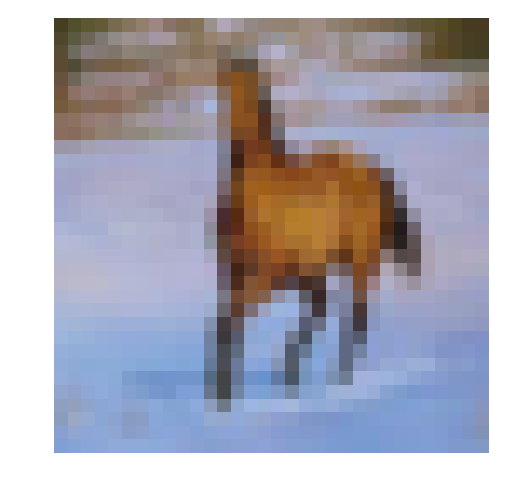

In [8]:
hide_code
batch_id = 5
sample_id = 10
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [9]:
hide_code
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    norm_x = x / 255
    return norm_x
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

**Hint:**

Look into LabelBinarizer in the preprocessing module of sklearn.

In [10]:
hide_code
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    x_categorical = ks.utils.to_categorical(x, num_classes=10)
    
    return x_categorical
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess All the Data and Save It
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [10]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

### Start Checkpoint
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [11]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the Network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [12]:
hide_code
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function    
    return tf.placeholder(tf.float32, shape = [None, image_shape[0], image_shape[1], image_shape[2]], name = 'x')

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=[None, n_classes], name = 'y')

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=None, name = 'keep_prob')

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
test_nn_image_inputs(neural_net_image_input)
test_nn_label_inputs(neural_net_label_input)
test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

** Hint: **

When unpacking values as an argument in Python, look into the [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) operator. 

In [13]:
hide_code
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function 
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.04))

    def bias_variable(shape):
        return tf.Variable(tf.constant(0.04, shape=shape))   
    
    layer1_weights = weight_variable([conv_ksize[0], conv_ksize[1], x_tensor.shape[3].value, conv_num_outputs])
    layer1_biases = bias_variable([conv_num_outputs])
       
    layer2_weights = weight_variable([conv_ksize[0], conv_ksize[1], conv_num_outputs, conv_num_outputs])
    layer2_biases = bias_variable([conv_num_outputs])
    
    layer3_weights = weight_variable([conv_ksize[0], conv_ksize[1], conv_num_outputs, conv_num_outputs])
    layer3_biases = bias_variable([conv_num_outputs])

    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    def conv2d2(x, W):
        return tf.nn.conv2d(x, W, strides=[1, conv_strides[0]//4, conv_strides[1]//4, 1], padding='SAME')
    def max_pool(x):
        return tf.nn.max_pool(x, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                              strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    def max_pool2(x):
        return tf.nn.max_pool(x, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                              strides=[1, pool_strides[0]//2, pool_strides[1]//2, 1], padding='SAME')
    
    h_conv1 = tf.nn.relu(conv2d(x_tensor, layer1_weights) + layer1_biases)
    h_pool1 = max_pool(h_conv1)
    
#    h_conv2 = tf.nn.relu(conv2d(h_pool1, layer2_weights) + layer2_biases)
#    h_pool2 = max_pool2(h_conv2)
    
#    h_conv3 = tf.nn.relu(conv2d(h_pool2, layer3_weights) + layer3_biases)
#    h_pool3 = max_pool(h_conv3)
    
    return h_pool1
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [14]:
hide_code
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = lambda i: x_tensor.shape[i].value
    size = shape(1) * shape(2) * shape(3)
    return tf.reshape(x_tensor, [-1, size])
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [15]:
hide_code
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
#    W1 = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, 64]))
#    b1 = tf.Variable(tf.truncated_normal([64]))
    W2 = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], stddev=0.04))
    b2 = tf.Variable(tf.truncated_normal([num_outputs], stddev=0.04))
    
#    hidden1 = tf.nn.relu(tf.add(tf.matmul(x_tensor, W1), b1))
    hidden2 = tf.nn.relu(tf.add(tf.matmul(x_tensor, W2), b2))
    return hidden2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [16]:
hide_code
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    W = tf.Variable(tf.truncated_normal([x_tensor.shape[1].value, num_outputs], stddev=0.04))
    b = tf.Variable(tf.truncated_normal([num_outputs], stddev=0.04))
    return tf.add(tf.matmul(x_tensor, W), b)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_output(output)

Tests Passed


### Create a Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [17]:
hide_code
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    x_tensor = conv2d_maxpool(x, conv_num_outputs=32, conv_ksize=(2, 2), conv_strides=(5, 5),
                               pool_ksize=(2, 2), pool_strides=(2, 2)) 
    x_tensor = conv2d_maxpool(x, conv_num_outputs=64, conv_ksize=(2, 2), conv_strides=(2, 2),
                               pool_ksize=(2, 2), pool_strides=(2, 2)) 
#    x_tensor = conv2d_maxpool(x, conv_num_outputs=64, conv_ksize=(2, 2), conv_strides=(2, 2),
#                               pool_ksize=(2, 2), pool_strides=(2, 2))
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
        
    x_tensor = flatten(x_tensor)
 
    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
       
    x_tensor = fully_conn(x_tensor, 512)
    x_tensor = tf.nn.dropout(x_tensor, keep_prob)    
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    x_tensor = output(x_tensor, 10)       
    
    # TODO: return output
    return x_tensor
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [21]:
hide_code
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [22]:
hide_code
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    cnn_cost = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.0})
    cnn_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    
    print('cost: {:.4f}, accuracy: {:.2f}%'.format(cnn_cost, cnn_accuracy * 100))

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [24]:
hide_code
epochs = 15
batch_size = 64
keep_probability = 0.77

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [25]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost: 1.9769, accuracy: 35.48%
Epoch  2, CIFAR-10 Batch 1:  cost: 1.7875, accuracy: 42.76%
Epoch  3, CIFAR-10 Batch 1:  cost: 1.6355, accuracy: 46.54%
Epoch  4, CIFAR-10 Batch 1:  cost: 1.5383, accuracy: 48.16%
Epoch  5, CIFAR-10 Batch 1:  cost: 1.4493, accuracy: 49.28%
Epoch  6, CIFAR-10 Batch 1:  cost: 1.3669, accuracy: 51.72%
Epoch  7, CIFAR-10 Batch 1:  cost: 1.2584, accuracy: 53.46%
Epoch  8, CIFAR-10 Batch 1:  cost: 1.2069, accuracy: 54.20%
Epoch  9, CIFAR-10 Batch 1:  cost: 1.1447, accuracy: 54.60%
Epoch 10, CIFAR-10 Batch 1:  cost: 1.0721, accuracy: 54.68%
Epoch 11, CIFAR-10 Batch 1:  cost: 1.0269, accuracy: 54.74%
Epoch 12, CIFAR-10 Batch 1:  cost: 0.9615, accuracy: 55.62%
Epoch 13, CIFAR-10 Batch 1:  cost: 0.8937, accuracy: 55.30%
Epoch 14, CIFAR-10 Batch 1:  cost: 0.8636, accuracy: 55.30%
Epoch 15, CIFAR-10 Batch 1:  cost: 0.8296, accuracy: 55.24%


### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [27]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost: 2.0124, accuracy: 34.26%
Epoch  1, CIFAR-10 Batch 2:  cost: 1.6807, accuracy: 40.20%
Epoch  1, CIFAR-10 Batch 3:  cost: 1.3868, accuracy: 45.14%
Epoch  1, CIFAR-10 Batch 4:  cost: 1.3994, accuracy: 49.86%
Epoch  1, CIFAR-10 Batch 5:  cost: 1.4464, accuracy: 51.44%
Epoch  2, CIFAR-10 Batch 1:  cost: 1.5783, accuracy: 50.88%
Epoch  2, CIFAR-10 Batch 2:  cost: 1.2188, accuracy: 51.78%
Epoch  2, CIFAR-10 Batch 3:  cost: 1.0800, accuracy: 52.76%
Epoch  2, CIFAR-10 Batch 4:  cost: 1.2364, accuracy: 55.62%
Epoch  2, CIFAR-10 Batch 5:  cost: 1.2310, accuracy: 56.16%
Epoch  3, CIFAR-10 Batch 1:  cost: 1.4610, accuracy: 55.02%
Epoch  3, CIFAR-10 Batch 2:  cost: 1.0045, accuracy: 56.26%
Epoch  3, CIFAR-10 Batch 3:  cost: 0.9742, accuracy: 55.46%
Epoch  3, CIFAR-10 Batch 4:  cost: 1.1175, accuracy: 57.48%
Epoch  3, CIFAR-10 Batch 5:  cost: 1.1076, accuracy: 58.32%
Epoch  4, CIFAR-10 Batch 1:  cost: 1.3218, accuracy: 57.88%
Epoch  4, CIFAR-10 Batch 2: 

### Next Checkpoint
The model has been saved to disk.

## Test the Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.6541600318471338



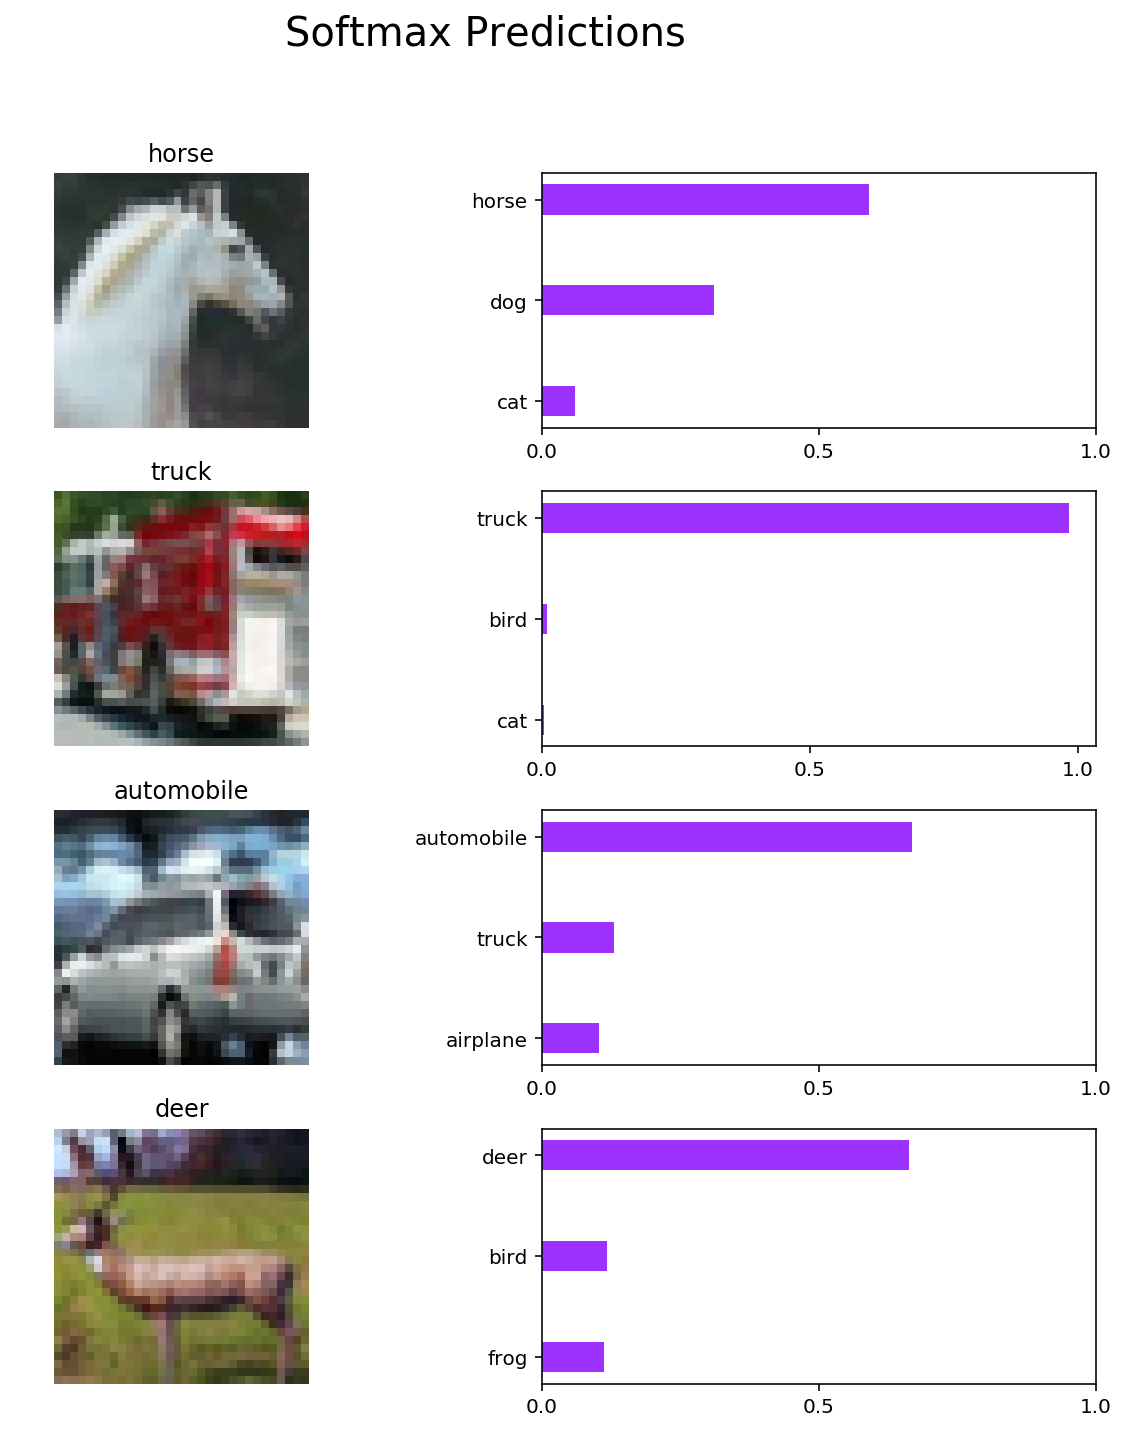

In [28]:
hide_code
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), 
                                                                            n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()

### Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to your model and we recemmond that once you are done with this project, you explore!

## Addition: CIFAR-10 and Keras

In [5]:
hide_code
# load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# normalize
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

(x_train, x_valid) = x_train[10000:], x_train[:10000]
(y_train, y_valid) = y_train[10000:], y_train[:10000]

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

# one hot encode
y_train = ks.utils.to_categorical(y_train, 10)
y_valid = ks.utils.to_categorical(y_valid, 10)
y_test = ks.utils.to_categorical(y_test, 10)

print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

x_train shape: (40000, 32, 32, 3)
x_valid shape: (10000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (40000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)


In [6]:
hide_code
def cnn_vgg_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    opt = ks.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])    
    return model

In [7]:
hide_code
cnn_vgg_model = cnn_vgg_model()
cnn_vgg_checkpointer = ModelCheckpoint(filepath='cnn_vgg_model.weights.best.hdf5', 
                                       verbose=2, save_best_only=True)

cnn_vgg_history = cnn_vgg_model.fit(x_train, y_train, 
                                    validation_data=(x_valid, y_valid),
                                    epochs=50, batch_size=64, verbose=2,
                                    callbacks=[cnn_vgg_checkpointer])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 1.61724, saving model to cnn_vgg_model.weights.best.hdf5
345s - loss: 1.8783 - acc: 0.3128 - val_loss: 1.6172 - val_acc: 0.4215
Epoch 2/50
Epoch 00001: val_loss improved from 1.61724 to 1.50149, saving model to cnn_vgg_model.weights.best.hdf5
324s - loss: 1.5790 - acc: 0.4247 - val_loss: 1.5015 - val_acc: 0.4649
Epoch 3/50
Epoch 00002: val_loss improved from 1.50149 to 1.39637, saving model to cnn_vgg_model.weights.best.hdf5
323s - loss: 1.4694 - acc: 0.4692 - val_loss: 1.3964 - val_acc: 0.4979
Epoch 4/50
Epoch 00003: val_loss improved from 1.39637 to 1.29443, saving model to cnn_vgg_model.weights.best.hdf5
299s - loss: 1.3846 - acc: 0.5057 - val_loss: 1.2944 - val_acc: 0.5382
Epoch 5/50
Epoch 00004: val_loss improved from 1.29443 to 1.22314, saving model to cnn_vgg_model.weights.best.hdf5
289s - loss: 1.3154 - acc: 0.5299 - val_loss: 1.2231 - val_acc: 0.5614
Epoch 6/50
Epoch 00005: 

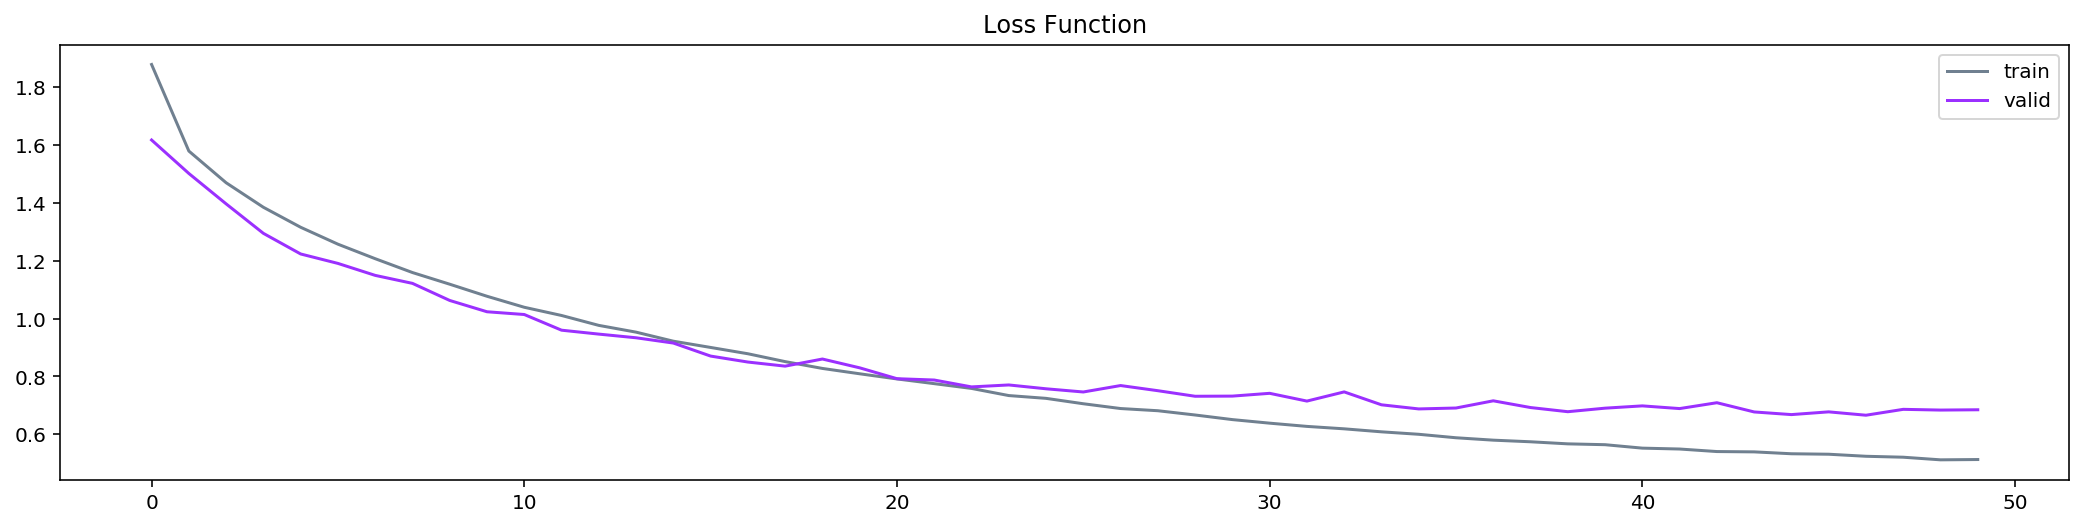

In [8]:
hide_code
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))
    plt.plot(fit_history.history['loss'], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'], color='#9b30ff', label = 'valid')

    plt.legend()
    plt.title('Loss Function');
    
loss_plot(cnn_vgg_history)

In [9]:
hide_code
cnn_vgg_model.load_weights('cnn_vgg_model.weights.best.hdf5')
cnn_vgg_scores = cnn_vgg_model.evaluate(x_test, y_test, verbose=0)

print("CNN VGG Model Scores: " , (cnn_vgg_scores))
print("CNN VGG Model Error: %.2f%%" % (100 - cnn_vgg_scores[1]*100))
print(cnn_vgg_model.summary())

CNN VGG Model Scores:  [0.6845423151493073, 0.77300000000000002]
CNN VGG Model Error: 22.70%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________

In [11]:
cnn_vgg_model.save('cnn_vgg_model_cifar10.h5')

 9984/10000 [============================>.] - ETA: 0s

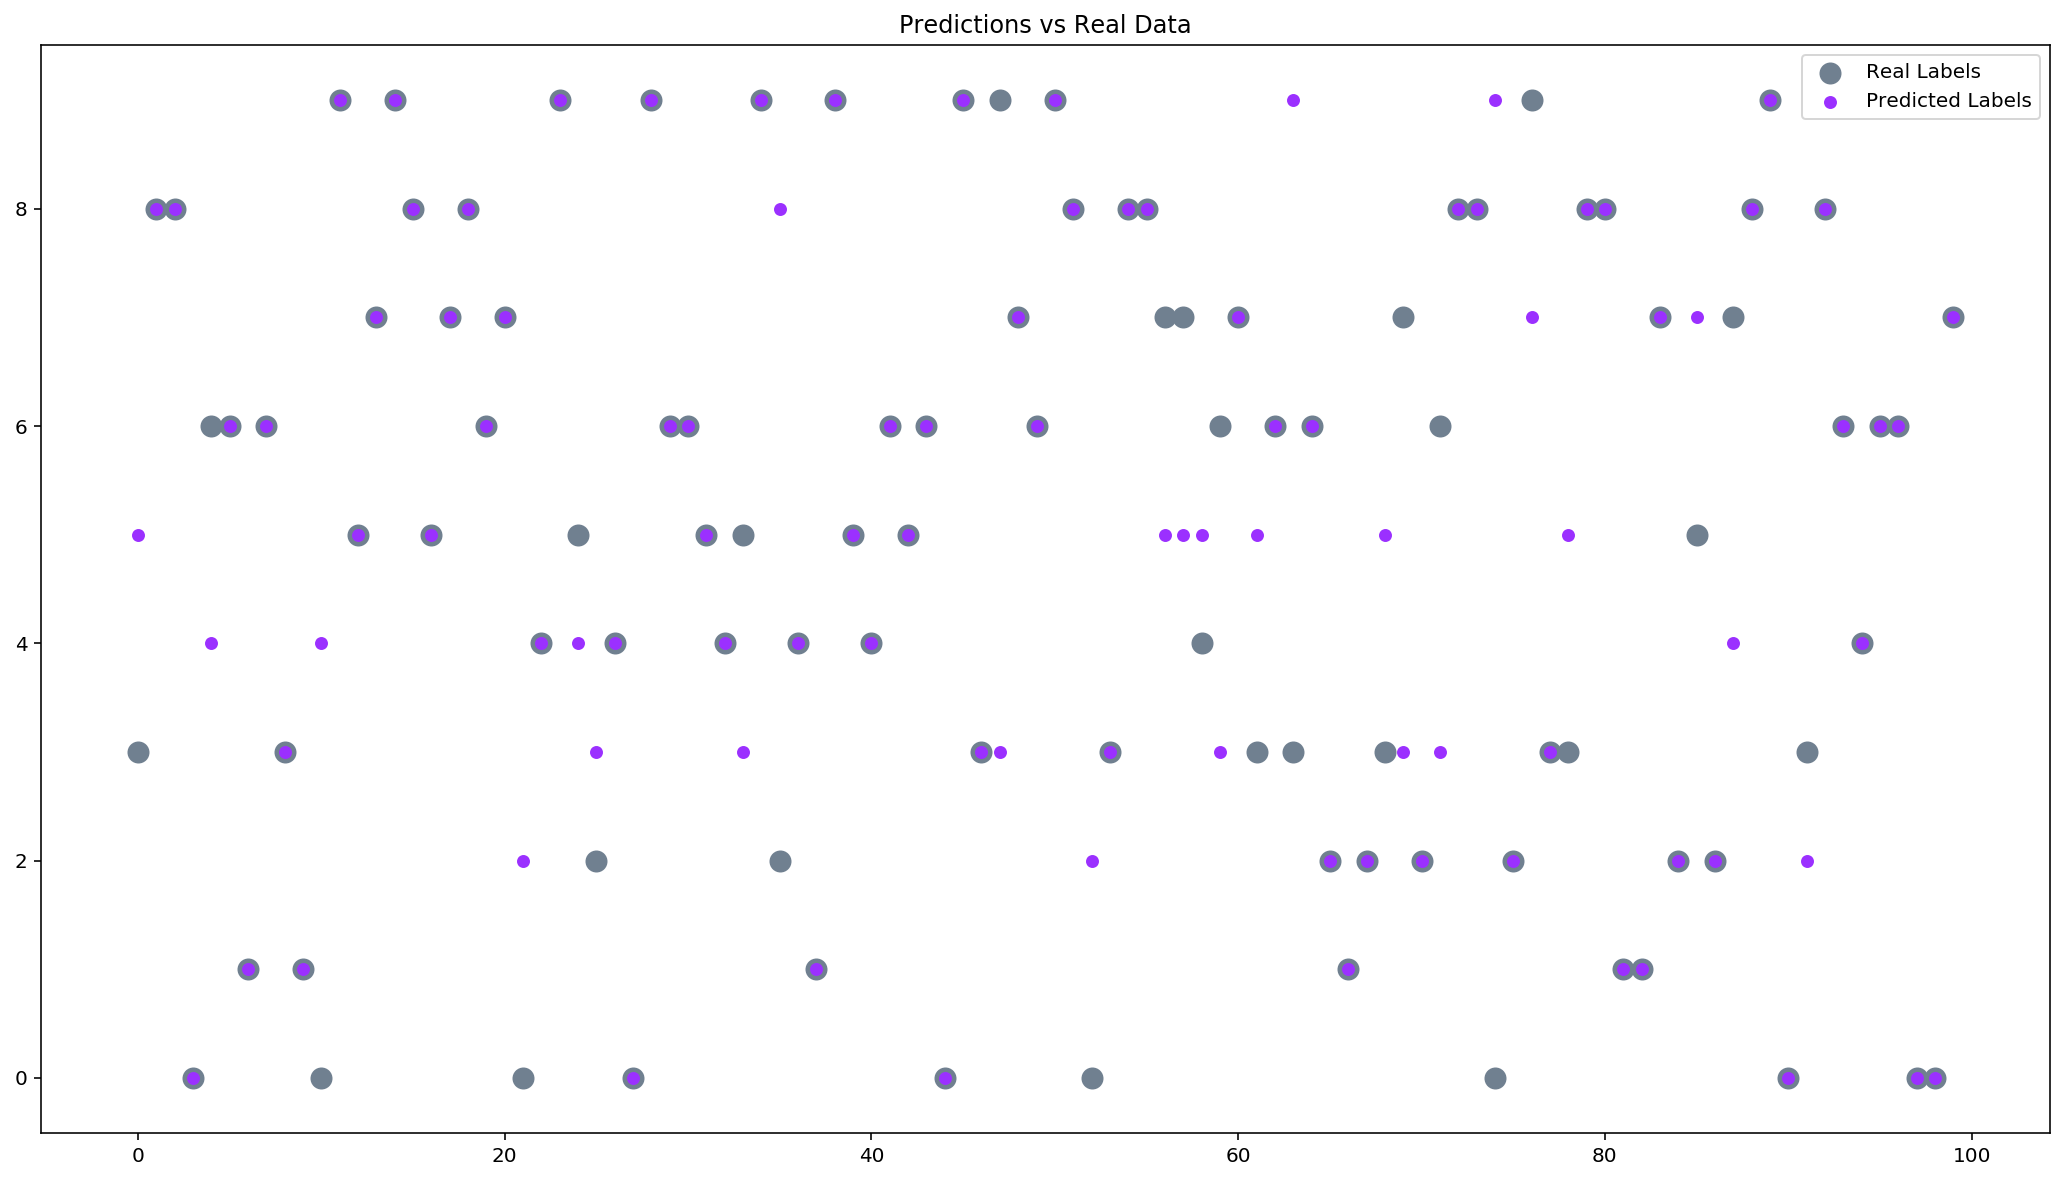

In [10]:
hide_code
y_test_cnn_vgg = cnn_vgg_model.predict_classes(x_test)
y_test_class = []
for i in range(10000):
    y_test_class.append(np.argmax(y_test[i]))
y_test_class = np.array(y_test_class)

plt.figure(figsize=(18,10))
plt.scatter(range(100), y_test_class[:100], 
            color='slategray', s=100, label='Real Labels')
plt.scatter(range(100), y_test_cnn_vgg[:100], 
            color='#9b30ff', s=30, label='Predicted Labels')
plt.legend()
plt.title('Predictions vs Real Data');

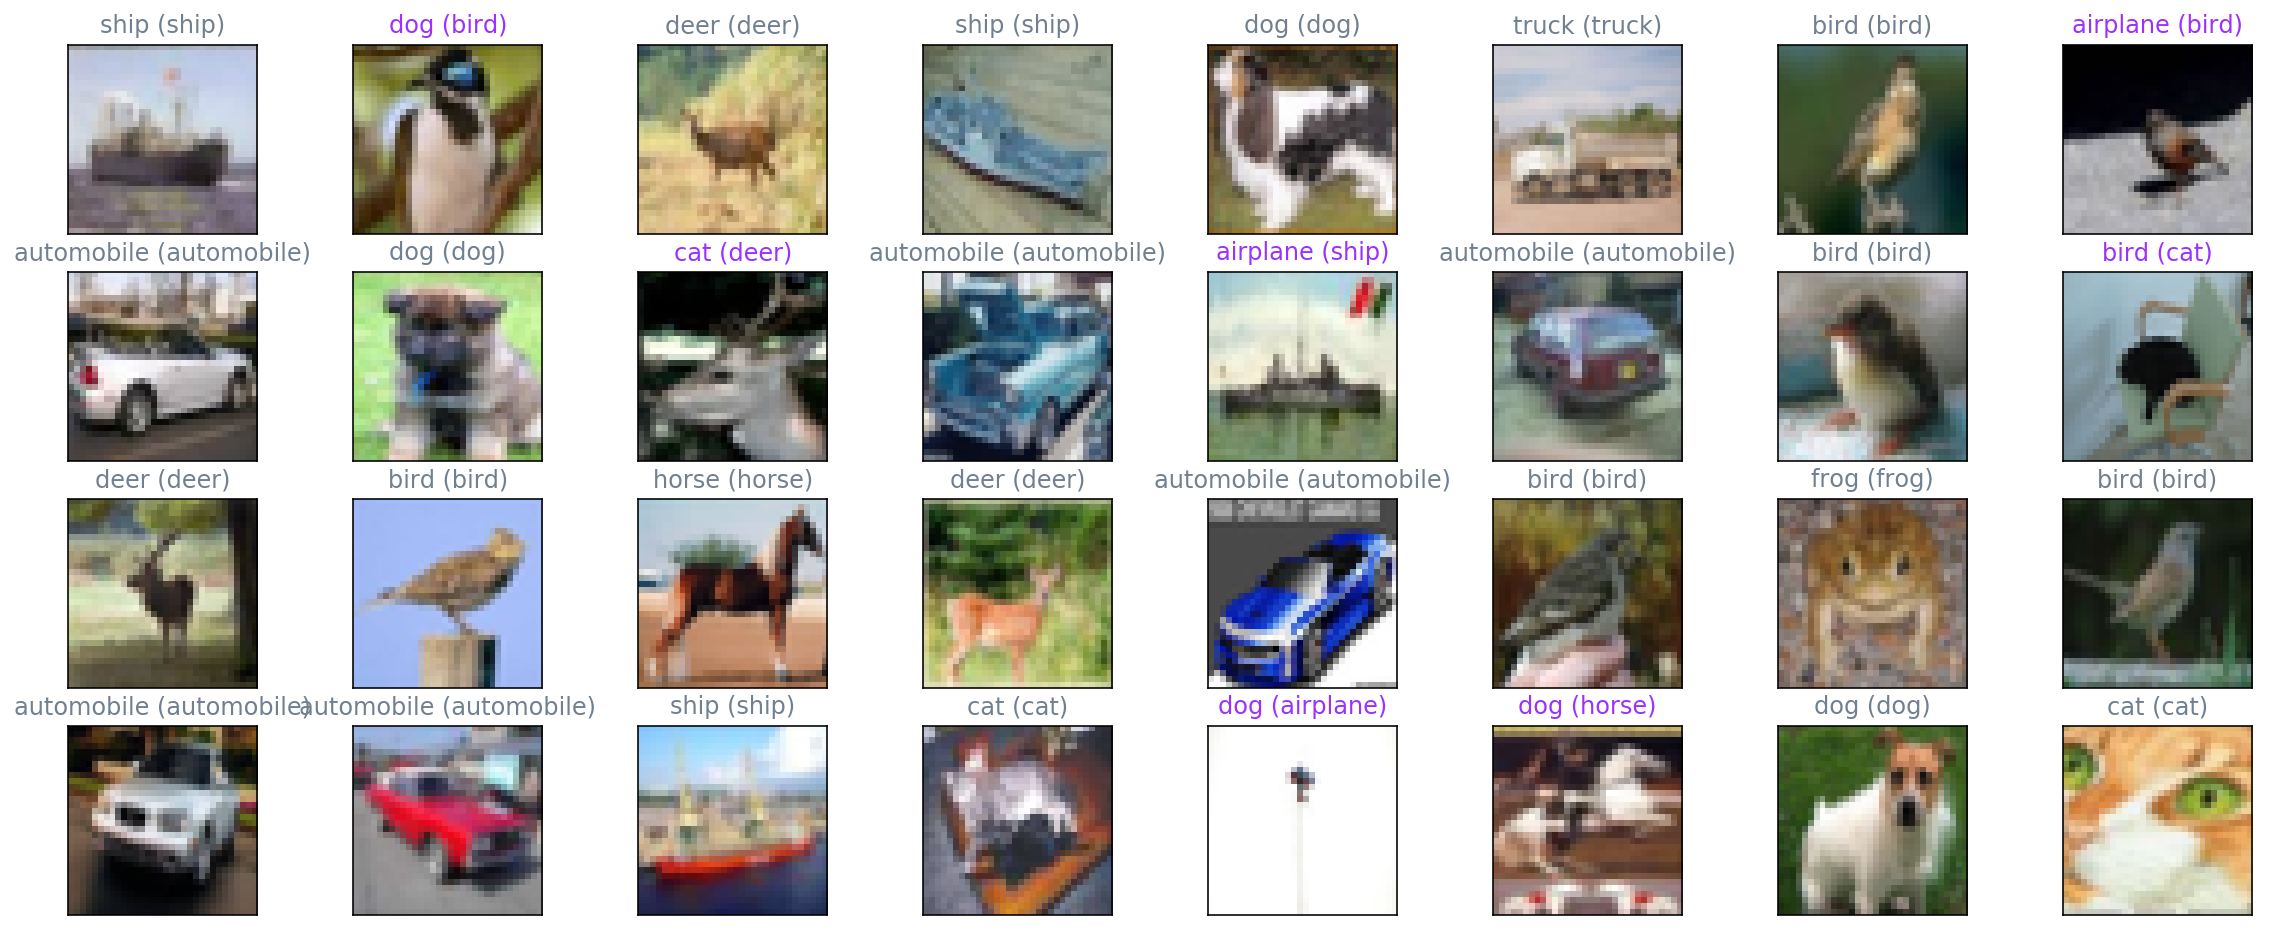

In [12]:
hide_code
cifar10_labels = _load_label_names()
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_cnn_vgg[idx]
    true_idx = y_test_class[idx]
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("slategray" if pred_idx == true_idx else "#9b30ff"))